In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import nlopt
from IPython.display import Video
from typing import NamedTuple
from mpl_toolkits.axes_grid1 import ImageGrid


Using MPI version 4.0, 1 processes
1.28.0


In [2]:

def straight_waveguide() -> (np.ndarray, NamedTuple):
    """Computes the DFT fields from the mode source in a straight waveguide
       for use as normalization of the reflectance measurement during the
       optimization.

    Returns:
      A 2-tuple consisting of a 1d array of DFT fields and DFT fields object
      returned by `meep.get_flux_data`.
    """

 

    Sx = 2*pml_size + 3 +1 # cell size in X
    Sy = 2*pml_size + 4*waveguide_width  # cell size in Y

    refl_pt =mp.Vector3(Sx/2 - pml_size-0.1)
    stop_cond = mp.stop_when_fields_decayed(50, mp.Ez, refl_pt, 1e-8)

    cell_size = mp.Vector3(Sx,Sy)

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            size=source_size,
            center=mp.Vector3(x= -Sx/2 + pml_size + 0.1),
            eig_band=1,
        )
    ]

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, waveguide_width),
            center=mp.Vector3(),
            material=Si,
        )
    ]

    sim = mp.Simulation(
        resolution=resolution,
        default_material=mp.air,
        cell_size=cell_size,
        sources=sources,
        geometry=geometry,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
    )

    refl_mon = sim.add_mode_monitor(
        frequencies,
        mp.ModeRegion(center= refl_pt, size=source_size),
        yee_grid=True,
    )

    sim.run(until_after_sources=stop_cond)

    res = sim.get_eigenmode_coefficients(
        refl_mon,
        [1],
    )

    coeffs = res.alpha
    input_flux = np.abs(coeffs[0, :, 0]) ** 2
    input_flux_data = sim.get_flux_data(refl_mon)

    return input_flux, input_flux_data





In [3]:
design= np.load("optimized_designs/design_data1.npy" ,allow_pickle=True)


In [4]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)


#minimum_length = 0.1 # (μm)
#eta_e = 0.75
#eta_i = 0.5
#eta_d = 1-eta_e
#filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

design_region_length = design[3] # (μm)
design_region_width = design[4] # (μm)


arm_separation = design[5]
waveguide_width = 0.5 # (μm)
waveguide_length = 2 # (μm)
pml_size = 1.0 # (μm)


In [5]:
Sx = 2*pml_size + waveguide_length/2 + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_size    = mp.Vector3(0,1,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size+0.2 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size+0.2 ,-arm_separation/2,0]



In [6]:

resolution = 20 # (pixels/μm)
design_region_resolution = 100 # (pixels/μm)
Nx = 400
Ny = 200

minimum_length=0.1

eta_e = 0.75
eta_i = 0.5
eta_d = 1-eta_e

filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)

nf=5
frequencies = 1/np.linspace(1.5,1.6,nf) 

x_g = np.linspace(
    -design_region_length / 2,
    design_region_length / 2,
    Nx,
)
y_g = np.linspace(
    -design_region_width / 2,
    design_region_width / 2,
    Ny,
)
X_g, Y_g = np.meshgrid(
    x_g,
    y_g,
    sparse=True,
    indexing="ij",
)

tl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)
                                                      
tr_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)

br_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)
                                                       
bl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)                                                      
                                                     

Si_mask = tl_wg_mask | tr_wg_mask | br_wg_mask | bl_wg_mask

border_mask = (
    (X_g <= -design_region_length / 2 + filter_radius)
    | (X_g >= design_region_length / 2 - filter_radius)
    | (Y_g <= -design_region_width / 2 + filter_radius)
    | (Y_g >= design_region_width / 2 - filter_radius)
)
Air_mask = border_mask.copy()
Air_mask[Si_mask] = False

def mapping(x: np.ndarray, eta: float, beta: float) -> np.ndarray:

    x = npa.where(Si_mask.flatten(), 1, npa.where(Air_mask.flatten(), 0, x.flatten()))

    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry

    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    return projected_field.flatten()
    






In [7]:
tot=495
fom=[]
top=[]
bot=[]
l=[]
mixed_dc_dataset=[]
mean_dist=np.zeros((400,200))
for i in range(tot):
    des=np.load('mixed_optimized_designs/gen_design_data'+str(i+1)+'.npy', allow_pickle=True)
    mixed_dc_dataset.append(des)
    mean_dist=mean_dist+des[0]
    fom.append(des[6][-1])
    top.append(des[9])
    bot.append(des[10])


mean_dist=mean_dist/tot
fom=np.array(fom)
top=np.array(top)
bot=np.array(bot)

for i in range(tot):
    if top[i,2]>0.45 and bot[i,2]>0.45:
        l.append(i)
        
mixed_dc_dataset=np.array(mixed_dc_dataset)
mixed_dc_dataset.shape
#np.save('mixed_dc_dataset.npy', mixed_dc_dataset)


(495, 12)

In [8]:
len(l), l[1]

(28, 55)

In [9]:
bot.shape

(495, 5)

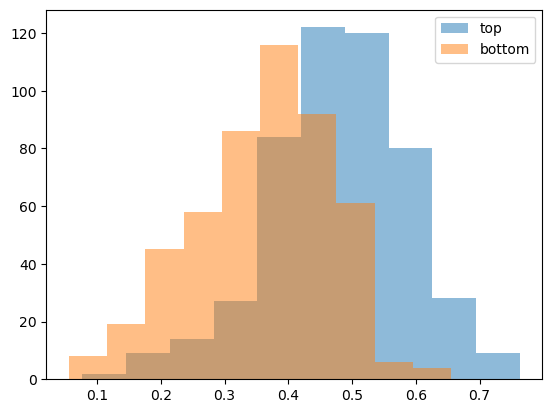

In [10]:
#plt.hist(fom, bins='auto')
plt.hist(top[:,2],label='top',alpha=.5)
plt.hist(bot[:,2],label='bottom',alpha=.5)
plt.legend()
plt.show()

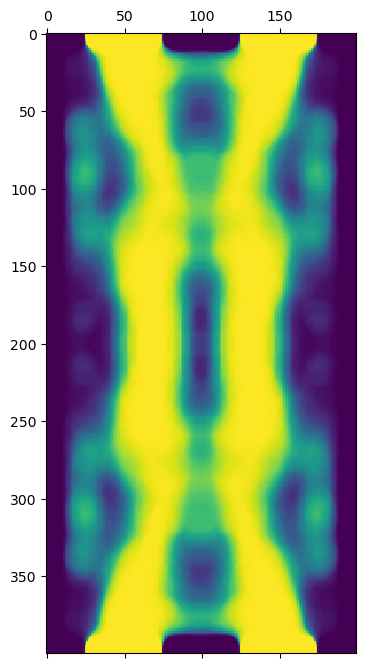

In [11]:
plt.matshow(mean_dist)

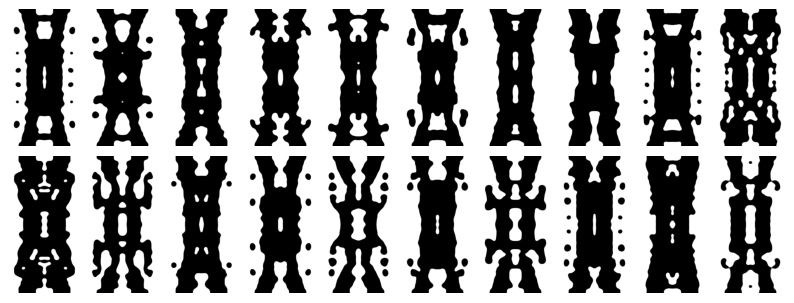

In [12]:
num_samples = 20
sample_images = []
r=np.random.choice(np.arange(len(mixed_dc_dataset)), size=num_samples, replace=False)
ll=l[:num_samples]

for i in range(num_samples):
    #sample_images.append(mixed_dc_dataset[r[i]][0])
    sample_images.append(mixed_dc_dataset[ll[i]][0])

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 10), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray_r')
    ax.axis('off')
    #plt.matshow(im)

plt.show()

In [13]:
#design= np.load("optimized_designs/design_data12.npy" ,allow_pickle=True)
#design= np.load("mixed_optimized_designs/gen_design_data603.npy" ,allow_pickle=True)#584
design= np.load("mixed_optimized_designs2/gen_design_data39.npy" ,allow_pickle=True)

resolution = design[1] # (pixels/μm)
design_region_resolution = design[2] # (pixels/μm)
Nx = design[0].shape[0]
Ny = design[0].shape[1]

nf=50
frequencies = design[8] #1/np.linspace(1.5,1.6,nf) 

top_profile = design[9]#np.abs(top_coef) ** 2/ input_flux
bottom_profile =  design[10] #np.abs(bottom_coef) ** 2 / input_flux
ref_profile = design[11]#np.abs(ref_coef) **2 / input_flux


In [14]:
'''14,21,23,26, 28, 30, 32, 44, 47, 66, 67, 69, 71, 74, 82, 83, 85, 87, 90,  581, 582, 597'''

'''good from50: 56, 59, 72, 73, 76, '''

'good from50: 56, 59, 72, 73, 76, '

In [15]:
#np.save("optimized_designs/design_data6.npy", design)

In [16]:
#from skimage.transform import resize

#des=np.load('/home/satadru/Nanophotonic_Design_Optimization_Using_Ising_Machine/MEEP codes/DC_2D_Dataset_generation/20.npy')
#design[0]=mapping(des, eta_i, 10).reshape(400, 200)

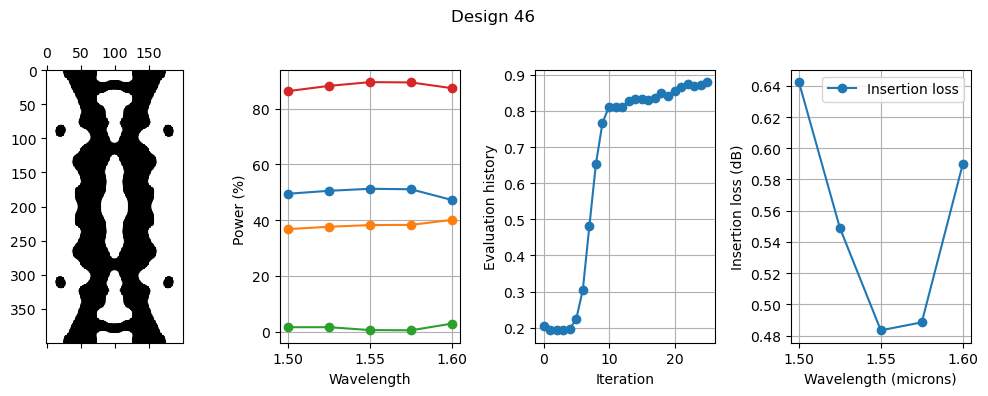

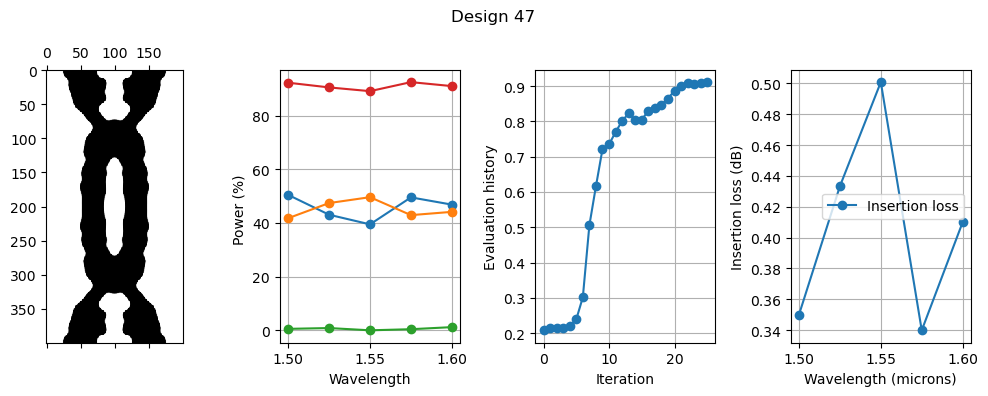

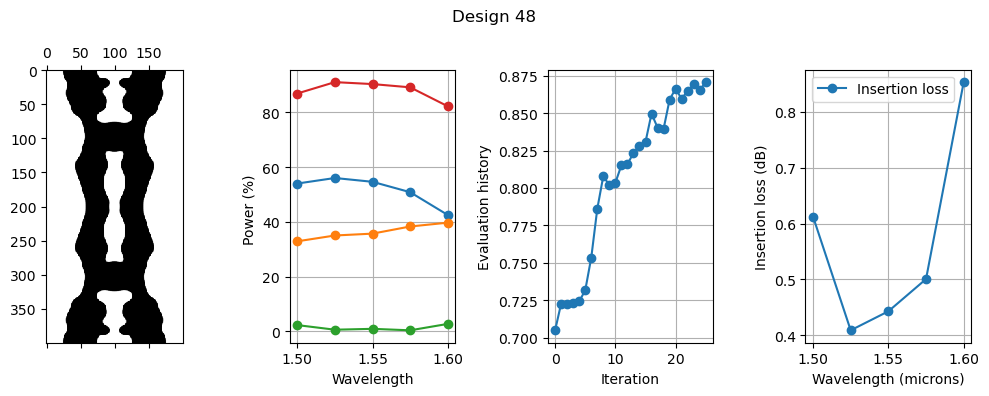

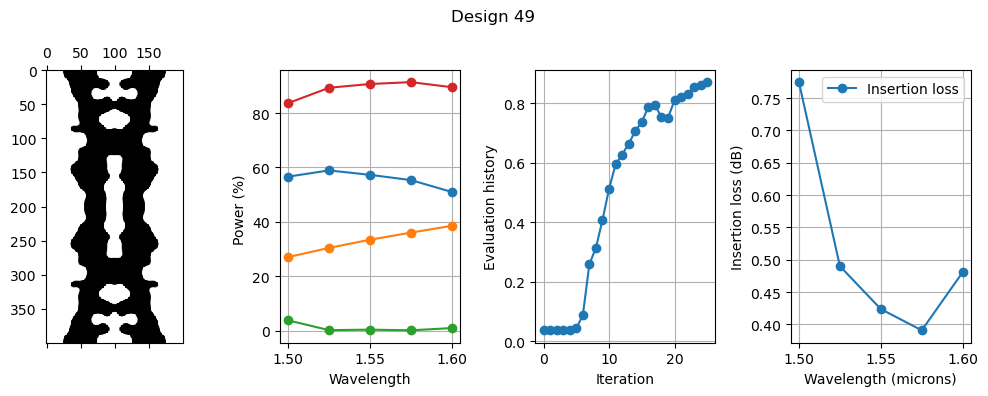

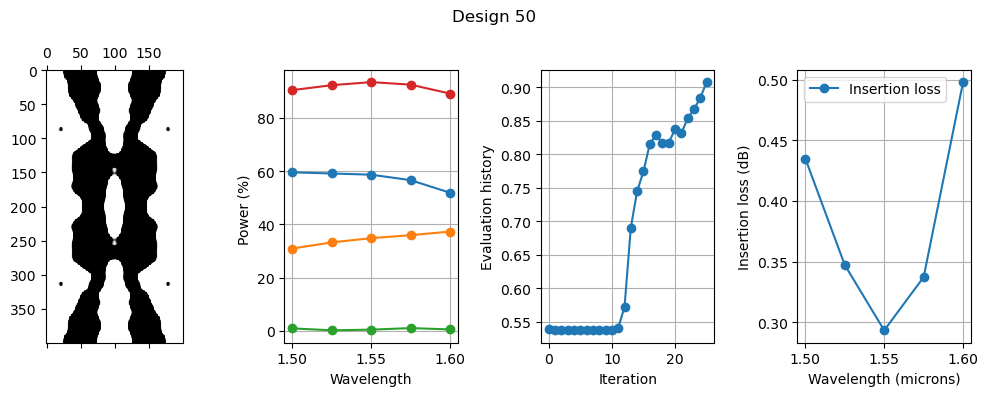

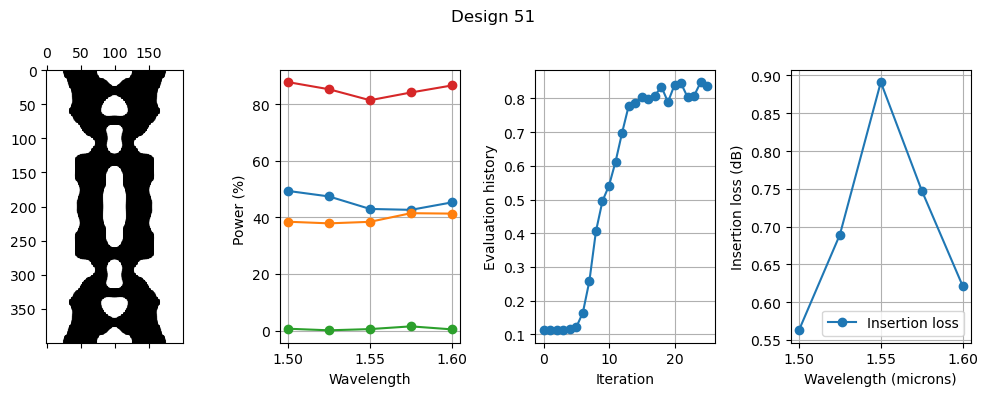

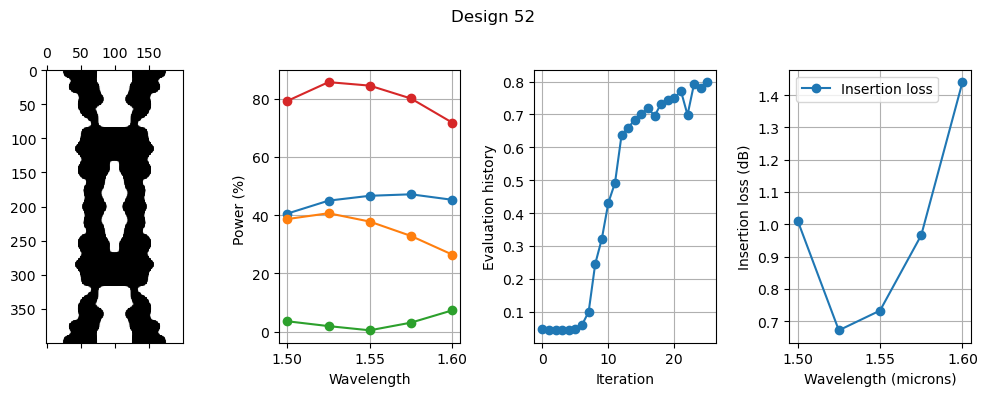

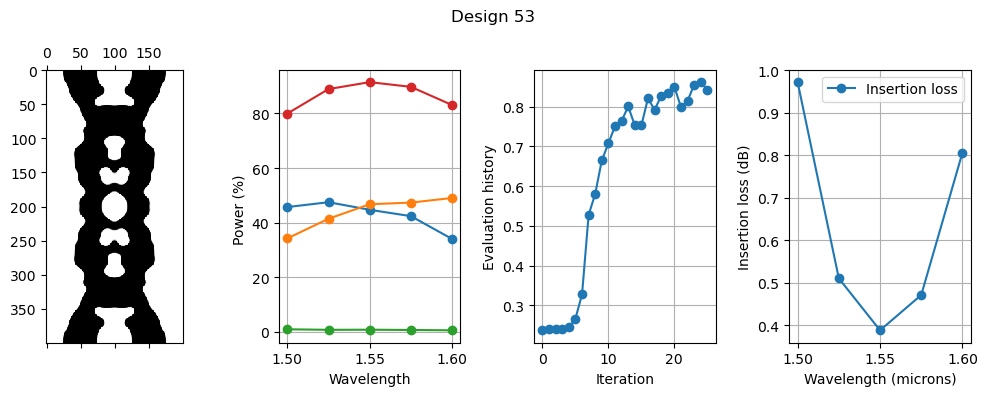

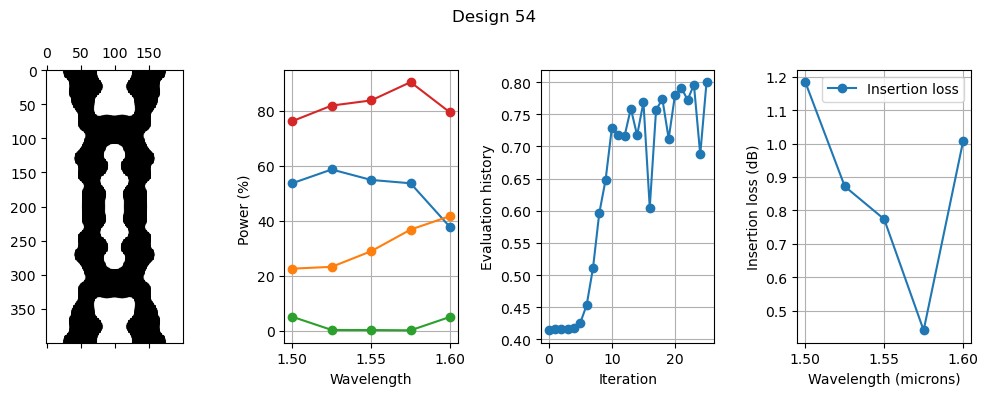

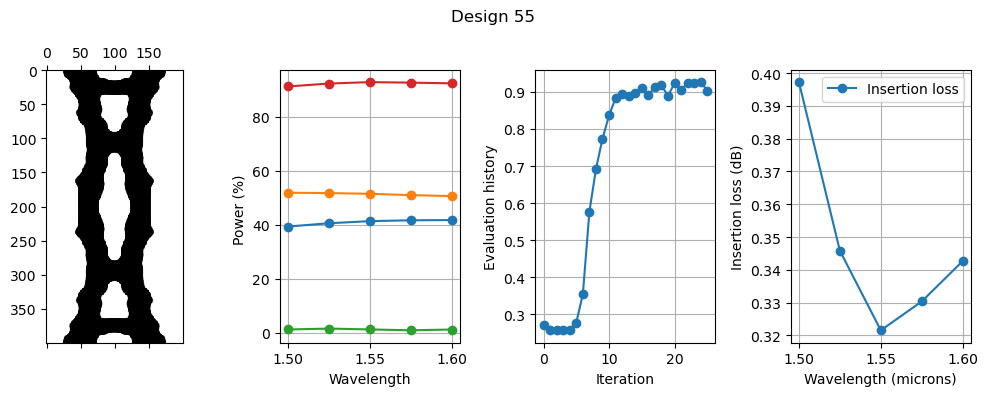

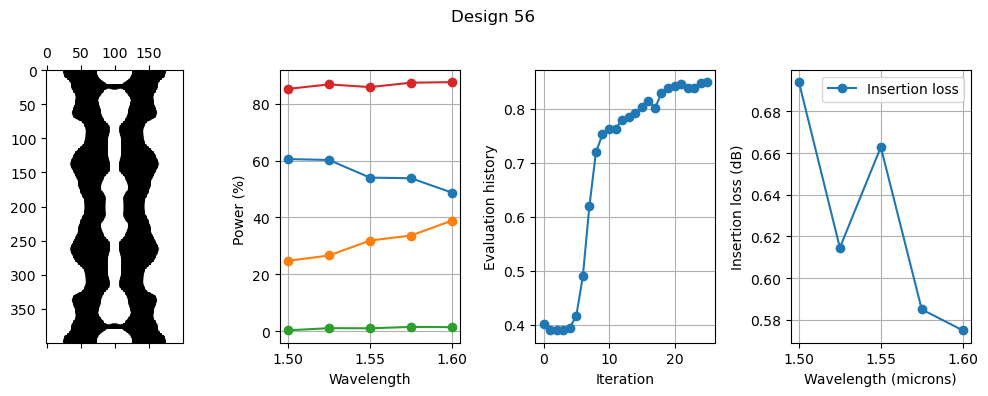

In [21]:
for i in range(46, 57):

    #design= np.load("optimized_designs/design_data" + str(i) + ".npy" ,allow_pickle=True)
    #design= np.load("mixed_optimized_designs/gen_design_data" + str(i) + ".npy" ,allow_pickle=True)#584
    design= np.load("mixed_optimized_designs2/gen_design_data" + str(i) + ".npy" ,allow_pickle=True)

    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(10,4),tight_layout=True)
    fig.suptitle('Design '+ str(i))
    #fig.tight_layout()
    ax1.matshow(design[0], cmap='gray_r')

    ax2.plot(1/frequencies,design[9]*100,'-o' ,label = 'Top Arm Output')
    ax2.plot(1/frequencies,design[10]*100,'-o',label = 'Bottom Arm Output')
    ax2.plot(1/frequencies,(design[11])*100,'-o',label = 'Input arm reflected')

    ax2.plot(1/frequencies,(design[9] + design[10])*100,'-o',label = 'Net output power (%)')
    ax2.grid(True)
    ax2.set_xlabel('Wavelength')
    ax2.set_ylabel('Power (%) ')
    #ax2.legend()

    ax3.plot(design[6],'o-')
    ax3.grid(True)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Evaluation history')

    ax4.plot(1/frequencies,-10 * np.log10(design[9] + design[10]),'-o' ,label = 'Insertion loss')
    ax4.legend()
    ax4.grid(True)
    ax4.set_xlabel('Wavelength (microns)')
    ax4.set_ylabel('Insertion loss (dB)')


Text(392.71486928104576, 0.5, 'Evaluation history')

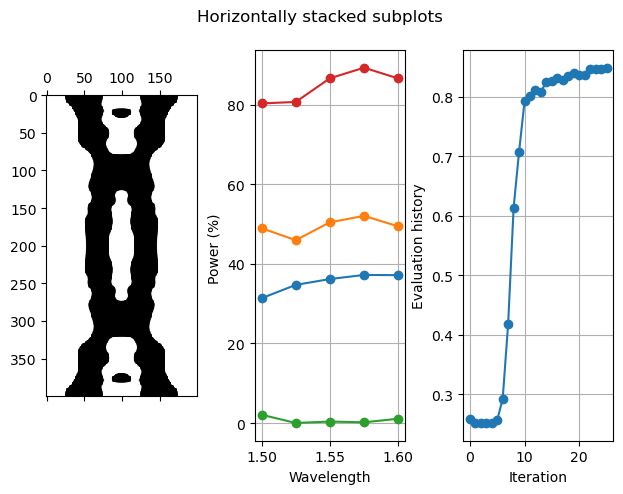

In [1771]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Horizontally stacked subplots')
fig.tight_layout()
ax1.matshow(design[0], cmap='gray_r')

ax2.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm Output')
ax2.plot(1/frequencies,bottom_profile*100,'-o',label = 'Bottom Arm Output')
ax2.plot(1/frequencies,(ref_profile)*100,'-o',label = 'Input arm reflected')

ax2.plot(1/frequencies,(top_profile + bottom_profile)*100,'-o',label = 'Net output power (%)')
ax2.grid(True)
ax2.set_xlabel('Wavelength')
ax2.set_ylabel('Power (%) ')
#ax2.legend()

ax3.plot(design[6],'o-')
ax3.grid(True)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Evaluation history')


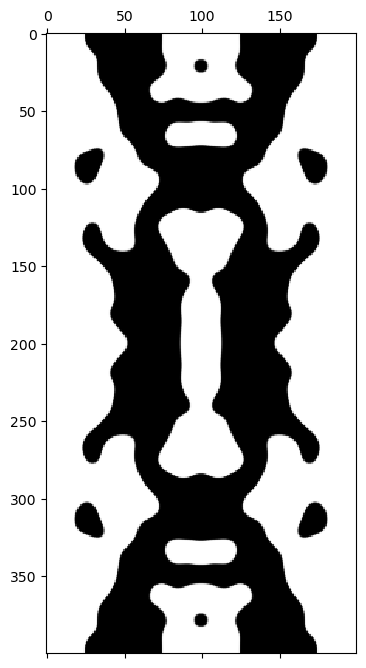

In [1723]:
plt.matshow(design[0], cmap='gray_r') 

In [1724]:
design[6].shape

(26,)

In [1725]:
#design[6]= np.mean(design[6], axis=1)

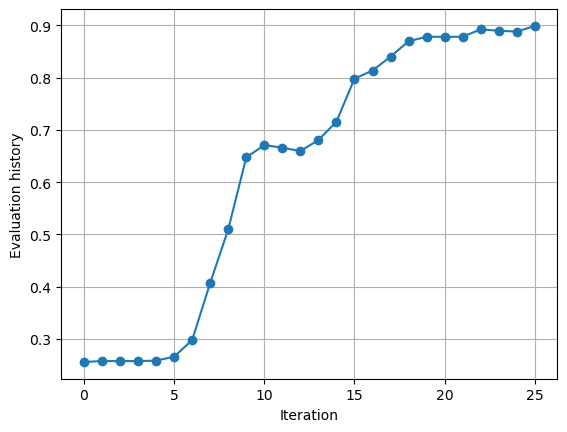

In [1726]:

plt.figure()
plt.plot(design[6],'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Evaluation history')
plt.show()


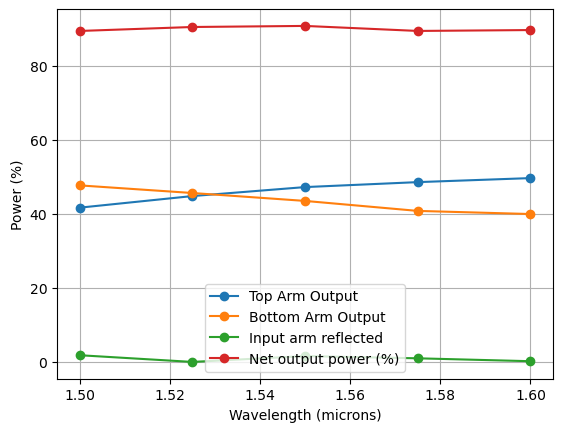

In [1727]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm Output')
plt.plot(1/frequencies,bottom_profile*100,'-o',label = 'Bottom Arm Output')
plt.plot(1/frequencies,(ref_profile)*100,'-o',label = 'Input arm reflected')

plt.plot(1/frequencies,(top_profile + bottom_profile)*100,'-o',label = 'Net output power (%)')

plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power (%)')
#plt.ylim(46.5,50)
plt.show()

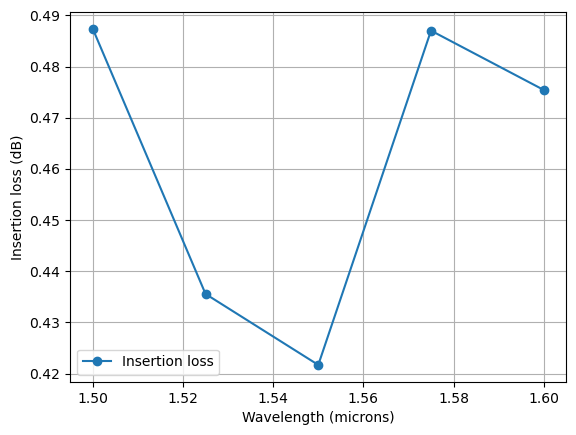

In [1728]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(top_profile + bottom_profile),'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss (dB)')
#plt.ylim(46.5,50)
plt.show()

In [1270]:
def dc_final_design_sim(
        final_weights: complex = design[0],
        beta: float = 0) -> mpa.OptimizationProblem:
    """Sets up the adjoint optimization of the waveguide mode converter.

    Args:
      use_damping: whether to use the damping feature of `MaterialGrid`.
      use_epsavg: whether to use subpixel smoothing in `MaterialGrid`.

    Returns:
      A `meep.adjoint.OptimizationProblem` class object.
    """


    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx,Ny),
        mp.air,
        Si,
        weights=final_weights,
        beta=beta,
    )

    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(), 
            size=mp.Vector3(design_region_length, design_region_width),
            ),
        )



    geometry = [
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
        mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
        mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
        mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]





    src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
    source = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.NO_DIRECTION,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center1)]



    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=source,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        default_material=mp.air,
                        resolution=resolution)



    mode = 1

    TE_ref = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(x=-(Sx/2 - pml_size - 0.4), y=arm_separation/2),
                size=source_size),mode, forward=False)
    TE_top = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),arm_separation/2,0),
                size=source_size),mode)
    TE_bottom = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=mp.Vector3(-(-Sx/2 + pml_size + 0.4),-arm_separation/2,0),
                size=source_size),mode)
    ob_list = [TE_ref,TE_top,TE_bottom]

    def J(source,top_output,bottom_output):
        power = npa.abs(top_output/source) **2 + npa.abs(bottom_output/source) **2
        return power
    


    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = J,
        objective_arguments = ob_list,
        design_regions = [design_region],
        frequencies=frequencies
    )
    return opt, geometry


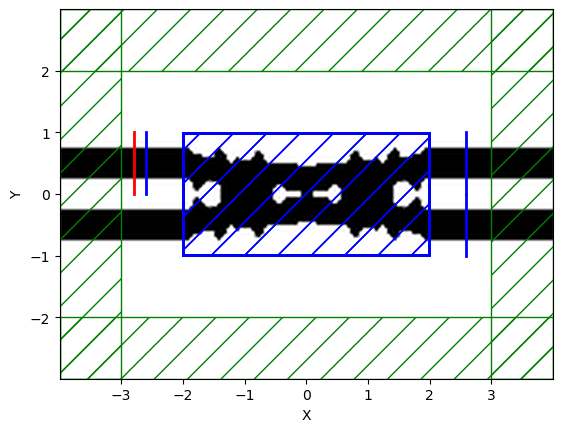

In [669]:
final_sim, geometry=dc_final_design_sim(beta=32)
final_sim.plot2D(True)

In [670]:
f0, dJ_du = final_sim(design[0].all(),need_gradient = False)
frequencies = final_sim.frequencies
ref_coef, top_coef, bottom_coef = final_sim.get_objective_arguments()



Starting forward run...


In [671]:
input_flux, input_flux_data = straight_waveguide()


In [672]:
# top_profile = np.abs(top_coef/source_coef) ** 2
# bottom_profile = np.abs(bottom_coef/source_coef) ** 2
frequencies=final_sim.frequencies

top_profile = np.abs(top_coef) ** 2/ input_flux
bottom_profile =  np.abs(bottom_coef) ** 2 / input_flux
ref_profile = np.abs(ref_coef) **2 / (input_flux)

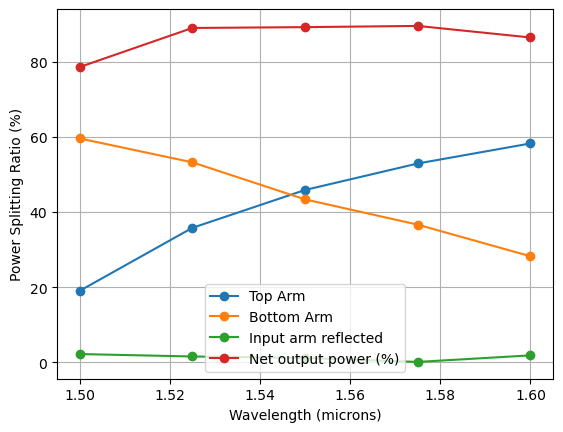

In [673]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'-o',label = 'Bottom Arm')
plt.plot(1/frequencies,(ref_profile)*100,'-o',label = 'Input arm reflected')

plt.plot(1/frequencies,(top_profile + bottom_profile)*100,'-o',label = 'Net output power (%)')

plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

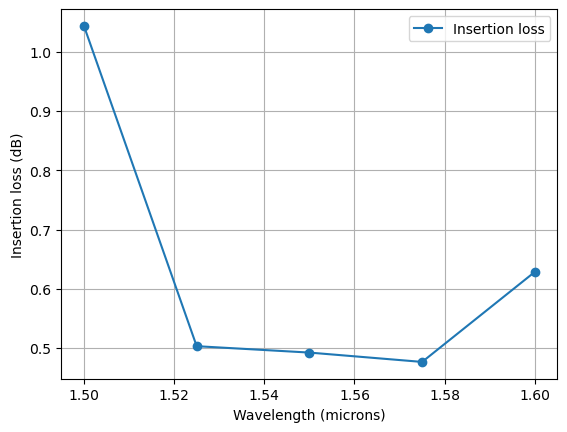

In [674]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(top_profile + bottom_profile),'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss (dB)')
#plt.ylim(46.5,50)
plt.show()

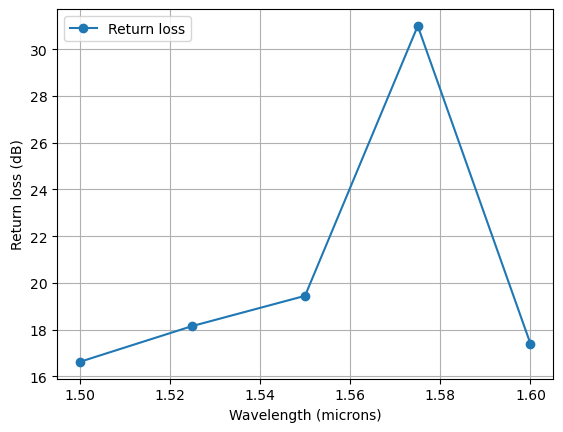

In [675]:
plt.figure()
plt.plot(1/frequencies,-10 * np.log10(ref_profile),'-o' ,label = 'Return loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Return loss (dB)')
#plt.ylim(46.5,50)
plt.show()

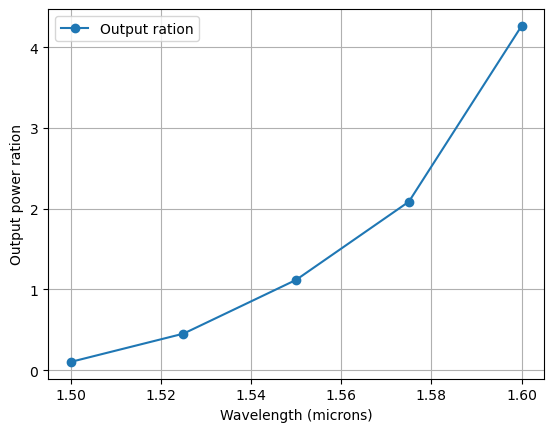

In [676]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_coef) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

<Axes: xlabel='X', ylabel='Y'>

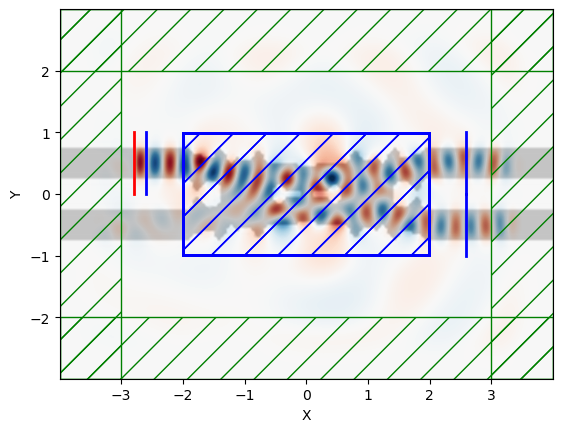

In [677]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
final_sim.sim.change_sources(source)
final_sim.sim.run(until=500)
final_sim.sim.plot2D(fields=mp.Ez)

In [678]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

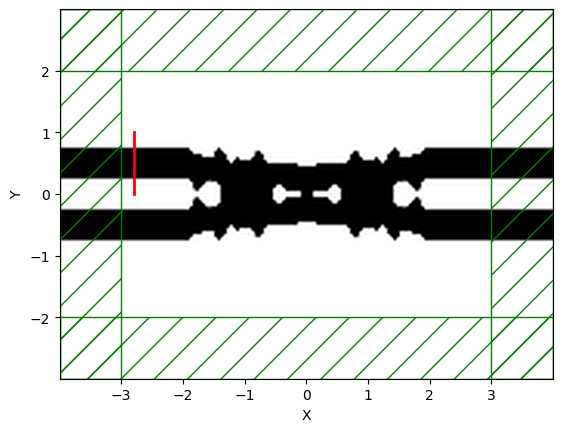

In [679]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [680]:
sim.run(until=100)


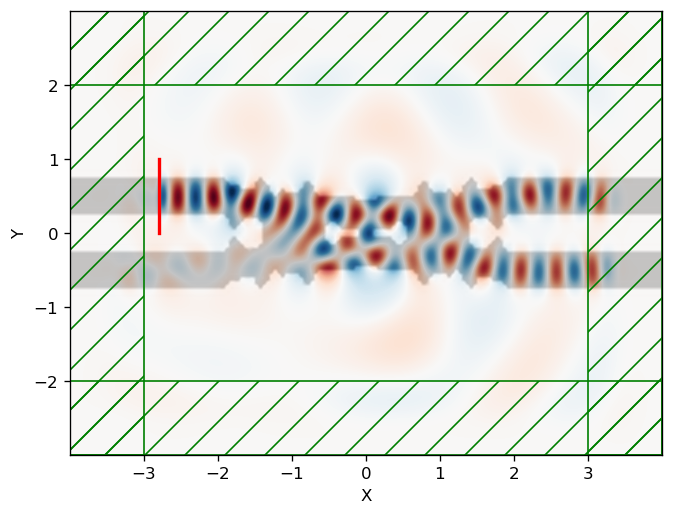

In [681]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [682]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [683]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [684]:
filename = "dc_lc1s_1.mp4"
Animate.to_mp4(10, filename)

In [685]:
Video(filename)


In [686]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

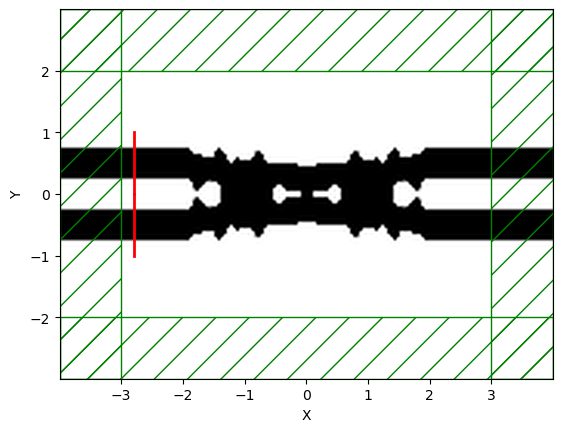

In [687]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [688]:
sim.run(until=300)


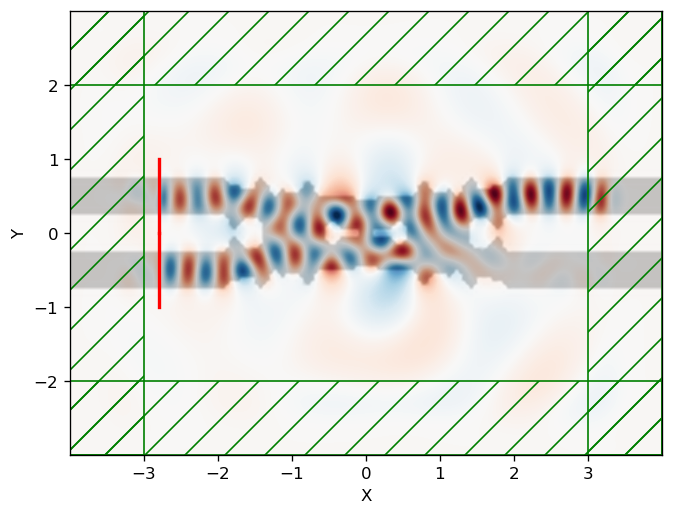

In [689]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [690]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [691]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [692]:
filename = "dc_lc_2s_1.mp4"
Animate.to_mp4(10, filename)

In [693]:
Video(filename)
